# Exploring the Outer Reaches of the DP0.2 Simulated Milky Way

Contact author: Jeff Carlin

Last verified to run on ???? with LSST Science Pipelines release version ???.

## Introduction

The goal of this notebook is to explore what we can learn about the structure of the Milky Way from the DP0.2 dataset. In particular, the 

- *Use this space to provide a brief description of what people will learn from this notebook.*
- *Include links to any information or precursor tutorials that would be useful.*
- *Give credit to all individuals who have contributed to this notebook or whose work this notebook is based on, if applicable.*

## 1.0 Set Up

In [1]:
# Import general python packages
import time
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import pandas
from pandas.testing import assert_frame_equal
from astropy import units as u
from astropy.coordinates import SkyCoord
import dustmaps
from dustmaps.sfd import SFDQuery
from dustmaps.config import config

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# To ignore some kinds of warnings
#import warnings
#from astropy.units import UnitsWarning

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.1.0/Linux64/dustmaps_cachedata/g41a3ec361e+62d12e78cb/config/.dustmapsrc


In [2]:
# Set up some plotting defaults:

params = {'axes.labelsize': 24,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 5],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [3]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

In [4]:
results = service.search("SELECT column_name, datatype, description, unit from TAP_SCHEMA.columns "
                         "WHERE table_name = 'dp02_dc2_catalogs.Object'")
sch = results.to_table()

In [11]:
# Define the query
query = "SELECT objectId, coord_ra, coord_dec, "\
        "scisql_nanojanskyToAbMag(u_psfFlux) as umag, "\
        "scisql_nanojanskyToAbMag(g_psfFlux) as gmag, "\
        "scisql_nanojanskyToAbMag(r_psfFlux) as rmag, "\
        "scisql_nanojanskyToAbMag(i_psfFlux) as imag, "\
        "scisql_nanojanskyToAbMag(z_psfFlux) as zmag, "\
        "scisql_nanojanskyToAbMag(y_psfFlux) as ymag, "\
        "scisql_nanojanskyToAbMagSigma(u_psfFlux, u_psfFluxErr) as umagerr, "\
        "scisql_nanojanskyToAbMagSigma(g_psfFlux, g_psfFluxErr) as gmagerr, "\
        "scisql_nanojanskyToAbMagSigma(r_psfFlux, r_psfFluxErr) as rmagerr, "\
        "scisql_nanojanskyToAbMagSigma(i_psfFlux, i_psfFluxErr) as imagerr, "\
        "scisql_nanojanskyToAbMagSigma(z_psfFlux, z_psfFluxErr) as zmagerr, "\
        "scisql_nanojanskyToAbMagSigma(y_psfFlux, y_psfFluxErr) as ymagerr, "\
        "tract, patch, i_extendedness, refExtendedness "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE (scisql_nanojanskyToAbMag(g_psfFlux)-scisql_nanojanskyToAbMag(r_psfFlux)) < 0.0 "\
        "AND (scisql_nanojanskyToAbMag(g_psfFlux)-scisql_nanojanskyToAbMag(r_psfFlux)) > -0.3 "\
        "AND scisql_nanojanskyToAbMag(g_psfFlux) < 26.0 "\
        "AND refExtendedness < 0.5"


The next cell executes the query. _Warning: it may take at least 15 minutes to return a result._

In [12]:
%%time
bhb_gr_color = service.search(query)
print('Query returned %s matched objects.' % len(bhb_gr_color))

Query returned 1699914 matched objects.
CPU times: user 1min 21s, sys: 1.21 s, total: 1min 23s
Wall time: 16min 31s


Instead of waiting for the query in the above cell to complete, you can submit an _asynchronous_ query. The following cells show how to do the same query asynchronously.

In [ ]:
#job = service.submit_job(query)

#print('Job URL is', job.url)

In [ ]:
#print('Job phase is', job.phase)

In [ ]:
#job.execution_duration

In [ ]:
#bhb_gr_color = job.fetch_result().to_table() #.to_pandas()

In [5]:
#bhb_gr_color_tab = bhb_gr_color.to_table()

In [19]:
#bhb_gr_color_tab.write('bhb_dp02_gr_selection.fits', overwrite=True)

In [6]:
from astropy.io import fits
#bhb_gr_color0 = fits.getdata('bhb_dp02_gr_selection.fits')
bhb_gr_color0 = fits.getdata('../../scratch/bhb_dp02_gr_selection.fits')

from astropy.table import Table
bhb_gr_color = Table(bhb_gr_color0)

In [7]:
bhb_gr_color.columns

<TableColumns names=('objectId','coord_ra','coord_dec','umag','gmag','rmag','imag','zmag','ymag','umagerr','gmagerr','rmagerr','imagerr','zmagerr','ymagerr','tract','patch','i_extendedness')>

### Correct the magnitudes for extinction

FIGURE OUT WHERE THE COEFFICIENTS CAME FROM!

In [8]:
# set the A_lamba/E(B-V) values for the six ugrizy LSST filters 
band_a_ebv = np.array([4.81,3.64,2.70,2.06,1.58,1.31])

In [9]:
coords = SkyCoord(bhb_gr_color['coord_ra'], bhb_gr_color['coord_dec'], unit = 'deg',frame='fk5')

In [10]:
sfd = SFDQuery()
ebvvec = sfd(coords)
bhb_gr_color.add_column(ebvvec, name='ebv')

In [11]:
u0 = bhb_gr_color['umag'] - bhb_gr_color['ebv']*band_a_ebv[0]
g0 = bhb_gr_color['gmag'] - bhb_gr_color['ebv']*band_a_ebv[1]
r0 = bhb_gr_color['rmag'] - bhb_gr_color['ebv']*band_a_ebv[2]
i0 = bhb_gr_color['imag'] - bhb_gr_color['ebv']*band_a_ebv[3]
z0 = bhb_gr_color['zmag'] - bhb_gr_color['ebv']*band_a_ebv[4]

For convenience, we'll extract extinction-corrected colors into arrays:

In [12]:
ug0 = u0-g0
ui0 = u0-i0
gr0 = g0-r0
rz0 = r0-z0
ri0 = r0-i0
iz0 = i0-z0

### Color-color plots

The method of selecting blue horizontal branch (BHB) stars that we intend to develop in this notebook is based on their unique locus in color-color space. First, let's look at a couple of color-color plots:

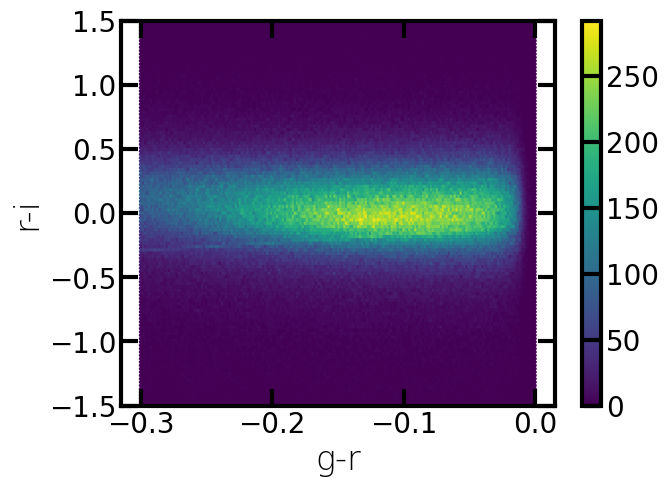

In [13]:
plt.hexbin(gr0, ri0, gridsize=200, extent=(-0.3, 0.0, -1.5, 1.5))
plt.colorbar()
plt.ylim(-1.5, 1.5)
plt.xlabel('g-r')
plt.ylabel('r-i')
plt.show()

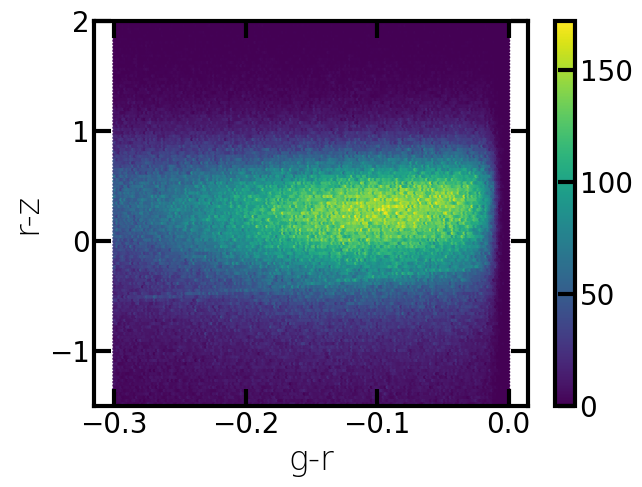

In [14]:
plt.hexbin(gr0, rz0, gridsize=200, extent=(-0.3, 0.0, -1.5, 2.0))
plt.colorbar()
plt.ylim(-1.5, 2)
plt.xlabel('g-r')
plt.ylabel('r-z')
plt.show()

You may have noticed a narrow stripe cutting across both of those color-color plots. Let's try to develop a way to select that stripe. It's a clear overdensity, and mostly horizontal, so we will try binning the data in the colors that are on the vertical axis in each plot, then see if there is a peak.

We'll do the following:
1. use a 2D histogram to bin the data, 
2. fit a polynomial to the overall distribution in each slice of (g-r) color,
3. subtract off the polynomial from the profile,
4. look for peaks in the residuals.

Because the BHB locus is a narrow stripe, it should remain after subtracting the smooth, low-order polynomial.

In [15]:
nbins=30
hist_grrz = np.histogram2d(gr0, rz0, range=[[-0.3, 0.0], [-1, 0]], bins=nbins)

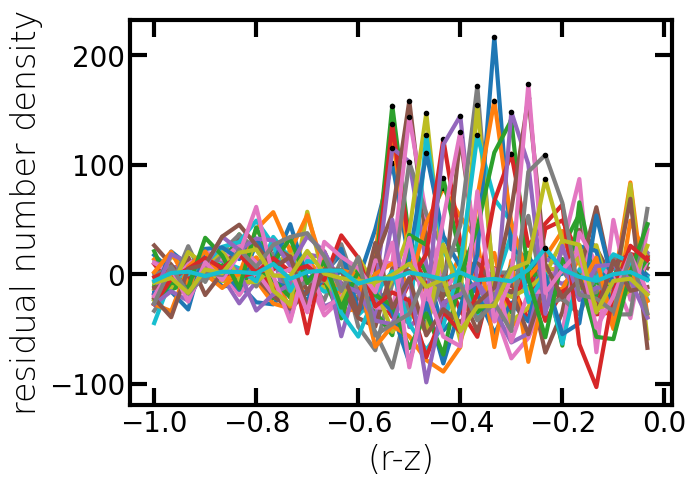

In [16]:
gr_binvals = []
rz_binvals = []

for x in range(nbins):
    poly = Polynomial.fit(hist_grrz[2][:-1], hist_grrz[0][x], deg=3)
    resid = hist_grrz[0][x]-poly(hist_grrz[2][:-1])
    plt.plot(hist_grrz[2][:-1], resid)
    peak = np.argmax(resid)
    plt.plot(hist_grrz[2][peak], resid[peak], 'k.')
    gr_binvals.append(hist_grrz[1][x])
    rz_binvals.append(hist_grrz[2][peak])
    # plt.plot(hist_grrz[2][:-1], hist_grrz[0][x])

plt.xlabel('(r-z)')
plt.ylabel('residual number density')
plt.show()

All we did was pick the highest peak in the residuals, and it looks like it may have worked. Let's fit a polynomial to the peaks we extracted.

In [17]:
poly_grrz0 = Polynomial.fit(gr_binvals, rz_binvals, deg=2)

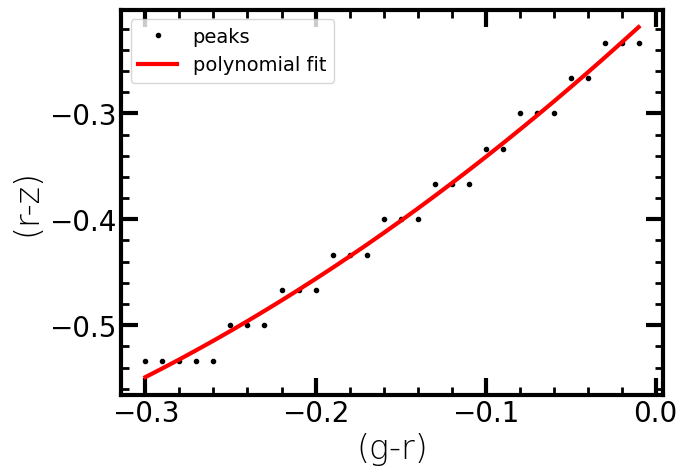

In [18]:
plt.plot(gr_binvals, rz_binvals, 'k.', label='peaks')
plt.plot(gr_binvals, poly_grrz0(np.array(gr_binvals)), 'r', label='polynomial fit')
plt.legend()
plt.xlabel('(g-r)')
plt.ylabel('(r-z)')
plt.minorticks_on()
plt.show()

Those were coarse bins. Let's try a finer scale:

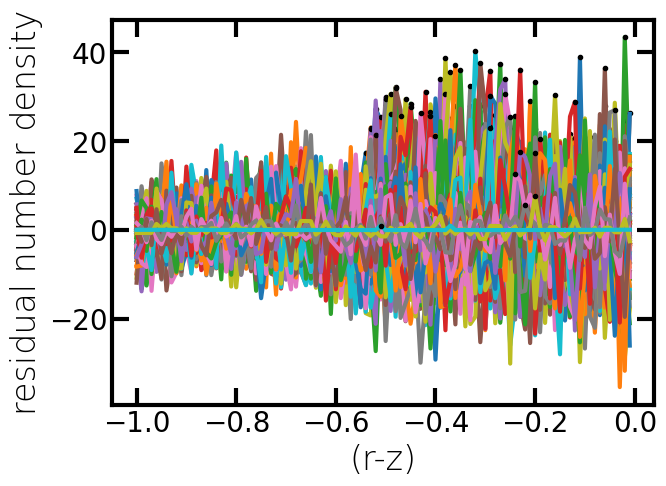

In [19]:
nbins=100
hist_grrz = np.histogram2d(gr0, rz0, range=[[-0.3, 0.0], [-1, 0]], bins=nbins)

gr_binvals = []
rz_binvals = []

for x in range(nbins):
    poly = Polynomial.fit(hist_grrz[2][:-1], hist_grrz[0][x], deg=3)
    resid = hist_grrz[0][x]-poly(hist_grrz[2][:-1])
    plt.plot(hist_grrz[2][:-1], resid)
    peak = np.argmax(resid)
    plt.plot(hist_grrz[2][peak], resid[peak], 'k.')
    gr_binvals.append(hist_grrz[1][x])
    rz_binvals.append(hist_grrz[2][peak])

plt.xlabel('(r-z)')
plt.ylabel('residual number density')

plt.show()

With finer bins, there will be some outliers. We'll calculate residuals relative to the previous, coarse polynomial to filter out points with large residuals, then fit a new polynomial.

In [20]:
rz_resid = rz_binvals-poly_grrz0(np.array(gr_binvals))
keepers = np.abs(rz_resid) < 0.05
gr_keepers = np.array(gr_binvals)[keepers]
rz_keepers = np.array(rz_binvals)[keepers]

poly_grrz = Polynomial.fit(gr_keepers, rz_keepers, deg=2)


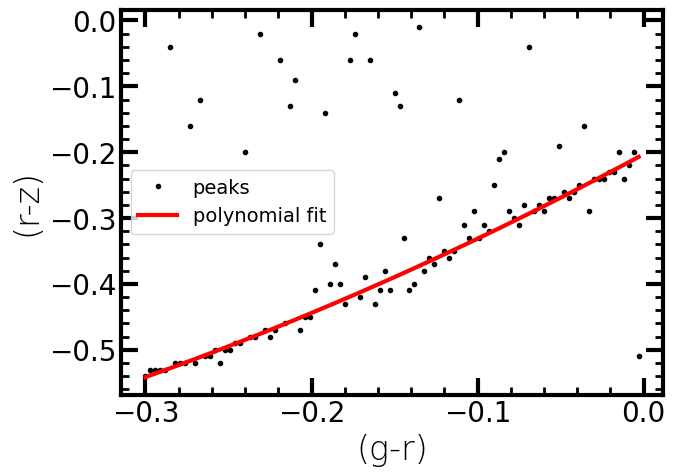

In [21]:
plt.plot(gr_binvals, rz_binvals, 'k.', label='peaks')
plt.plot(gr_binvals, poly_grrz(np.array(gr_binvals)), 'r', label='polynomial fit')
plt.legend()
plt.xlabel('(g-r)')
plt.ylabel('(r-z)')
plt.minorticks_on()
plt.show()